<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_02_03_survival_analysis_stratified_cox_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.3 Stratified Cox Model


This tutorial explains the concept of **Stratified Cox Model** in
survival analysis, why they are important, how to implement them, and
the assumptions involved. It also provides practical examples and code
snippets in R.


## Overview


The Stratified Cox Proportional Hazards Model is a modification of the
standard Cox Proportional Hazards (PH) model, which is a semi-parametric
method used in survival analysis to assess the impact of covariates on
the hazard rate of an event (e.g., death, failure) over time. The
standard Cox model assumes that the hazard ratios are constant over time
(the PH assumption), meaning the effect of covariates on the hazard is
proportional and does not change.

However, this assumption can be violated for certain covariates, such as
categorical factors like treatment group or tumor type, where the hazard
functions cross or diverge non-proportionally. The stratified version
addresses this by dividing the data into strata based on the levels of
the violating covariate (e.g., different categories of a variable).
Within each stratum, a separate baseline hazard function ( h\_{0j}(t) )
is estimated, allowing it to vary across strata. The model takes the
form:

$$
h_{ij}(t) = h_{0j}(t) \exp(\mathbf{x}_i^T \boldsymbol{\beta})
$$

where: - $i$ indexes individuals, - $j$ indexes strata, - $h_{0j}(t)$ is
the stratum-specific baseline hazard, - $\mathbf{x}_i$ are the
covariates (excluding the stratification variable), -
$\boldsymbol{\beta}$ are the regression coefficients, assumed to be the
same across all strata.

This approach controls for the stratifying variable without estimating a
coefficient for it, meaning you cannot directly test or quantify its
effect on the hazard. The partial likelihood is the product of
stratum-specific likelihoods, and estimation proceeds by summing
contributions from each stratum (e.g., via Newton-Raphson optimization).


### Key advantages


-   Handles non-PH for the stratifying variable without needing
    time-dependent covariates.
-   Useful for sensitivity analyses or when the stratifying factor is a
    confounder (e.g., study site in multi-center trials).


## Limitations


-   Reduces statistical efficiency slightly if stratification is
    unnecessary.
-   No inference (e.g., p-values) for the stratification variable.
-   Best for categorical variables with few levels; challenging for
    continuous or many-level variables.

The PH assumption must still hold within each stratum for the remaining
covariates. Diagnostics like Schoenfeld residuals (via `cox.zph()` in R)
or plots of log cumulative hazards can check for violations before
deciding to stratify.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316564 sha256=84b1aacd954842df8809a9a835f5aa5c32197416ebe3d3a2e33cbf91f280ea90
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Stratified Cox Model in R


We uses the `survival` package in R to fit and interpret a stratified
Cox model. We'll use the built-in `lung` dataset from the package, which
contains survival data for 228 patients with advanced lung cancer. Key
variables include: - `time`: Survival time in days. - `status`:
Censoring indicator (1 = censored, 2 = dead). - `age`: Age in years. -
`sex`: Sex (1 = male, 2 = female). - `wt.loss`: Weight loss in the last
six months (in pounds).

(Note: In practice, recode `status` to 0/1 for censored/event if needed,
but here it's already suitable after adjustment.)


### Install Required R Packages


Following R packages are required to run this notebook. If any of these
packages are not installed, you can install them using the code below:


In [ ]:
%%R
packages <-c(
		 'tidyverse',
		 'performance',
		 'gtsummary',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'joineR'
		 )


### Install missing packages

In [ ]:
%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis")

### Verify installation

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom



     tidyverse    performance      gtsummary       survival      survminer 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggsurvfit     tidycmprsk      ggfortify        timereg         cmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
      condSURV riskRegression         joineR 
          TRUE           TRUE           TRUE 


### Load Packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:joineR"         "package:riskRegression" "package:condSURV"      
 [4] "package:cmprsk"         "package:timereg"        "package:ggfortify"     
 [7] "package:tidycmprsk"     "package:ggsurvfit"      "package:survminer"     
[10] "package:ggpubr"         "package:survival"       "package:gtsummary"     
[13] "package:performance"    "package:lubridate"      "package:forcats"       
[16] "package:stringr"        "package:dplyr"          "package:purrr"         
[19] "package:readr"          "package:tidyr"          "package:tibble"        
[22] "package:ggplot2"        "package:tidyverse"      "package:tools"         
[25] "package:stats"          "package:graphics"       "package:grDevices"     
[28] "package:utils"          "package:datasets"       "package:methods"       
[31] "package:base"          


### Data


We will be utilizing the `lung` dataset from the {survival} package,
which serves as a valuable resource for analyzing survival data. This
dataset comprises information from subjects diagnosed with advanced lung
cancer, specifically gathered from the North Central Cancer Treatment
Group, a prominent clinical trial network dedicated to cancer research.
This dataset has 228 observations and 10 variables. For analysis, we'll
focus on `time`, `status`, `age`, `sex`, and `wt.loss`.


In [ ]:
%%R
# Load veteran  dataset
data(lung)
glimpse(lung)

Rows: 228
Columns: 10
$ inst      <dbl> 3, 3, 3, 5, 1, 12, 7, 11, 1, 7, 6, 16, 11, 21, 12, 1, 22, 16…
$ time      <dbl> 306, 455, 1010, 210, 883, 1022, 310, 361, 218, 166, 170, 654…
$ status    <dbl> 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ age       <dbl> 74, 68, 56, 57, 60, 74, 68, 71, 53, 61, 57, 68, 68, 60, 57, …
$ sex       <dbl> 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, …
$ ph.ecog   <dbl> 1, 0, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, NA, 1, 1, 1, 2, 2, 1,…
$ ph.karno  <dbl> 90, 90, 90, 90, 100, 50, 70, 60, 70, 70, 80, 70, 90, 60, 80,…
$ pat.karno <dbl> 100, 90, 90, 60, 90, 80, 60, 80, 80, 70, 80, 70, 90, 70, 70,…
$ meal.cal  <dbl> 1175, 1225, NA, 1150, NA, 513, 384, 538, 825, 271, 1025, NA,…
$ wt.loss   <dbl> NA, 15, 15, 11, 0, 0, 10, 1, 16, 34, 27, 23, 5, 32, 60, 15, …


### Fit a Standard (Unstratified) Cox Model


First, fit a standard Cox model to assess covariates and check the PH
assumption.


In [ ]:
%%R
# Fit the model
lung_cox <- coxph(Surv(time, status == 2) ~ age + sex + wt.loss, data = lung)
# Summary of results
summary(lung_cox)

Call:
coxph(formula = Surv(time, status == 2) ~ age + sex + wt.loss, 
    data = lung)

  n= 214, number of events= 152 
   (14 observations deleted due to missingness)

              coef  exp(coef)   se(coef)      z Pr(>|z|)   
age      0.0200882  1.0202913  0.0096644  2.079   0.0377 * 
sex     -0.5210319  0.5939074  0.1743541 -2.988   0.0028 **
wt.loss  0.0007596  1.0007599  0.0061934  0.123   0.9024   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

        exp(coef) exp(-coef) lower .95 upper .95
age        1.0203     0.9801    1.0011    1.0398
sex        0.5939     1.6838    0.4220    0.8359
wt.loss    1.0008     0.9992    0.9887    1.0130

Concordance= 0.612  (se = 0.027 )
Likelihood ratio test= 14.67  on 3 df,   p=0.002
Wald test            = 13.98  on 3 df,   p=0.003
Score (logrank) test = 14.24  on 3 df,   p=0.003




Interpretation: Age and sex are significant predictors (higher age
increases hazard; females have lower hazard). Weight loss is not
significant.


### Check the Proportional Hazards Assumption


Use Schoenfeld residuals to test PH.


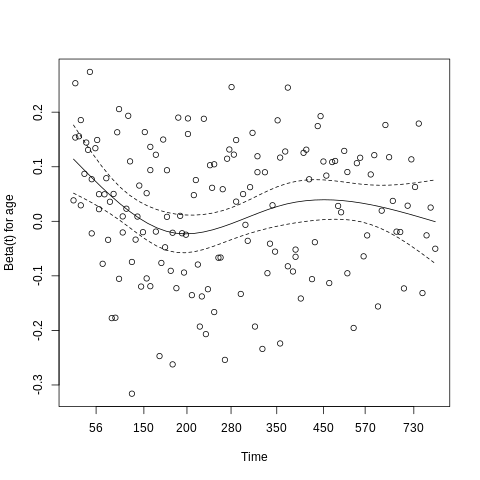

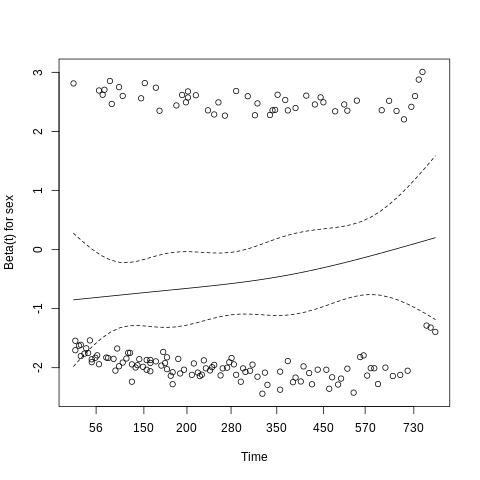

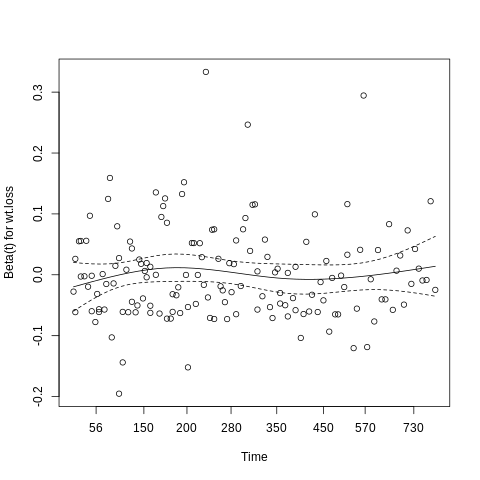

In [ ]:
%%R
# Test PH assumption
ph_test <- cox.zph(lung_cox)
ph_test
plot(ph_test)  # Visual check for each covariate


If the p-values in `ph_test` are low (e.g., \<0.05 for `sex`), it
indicates a violation. Plots should show flat lines around zero for
residuals vs. time if PH holds. Suppose `sex` violates PH; this
motivates stratification.


### Fit the Stratified Cox Model


Stratify by the violating variable (e.g., `sex`). This allows different
baseline hazards for males and females.


In [ ]:
%%R
# Fit stratified model
lung_strat_sex <- coxph(Surv(time, status == 2) ~ age + wt.loss + strata(sex), data = lung)
# Summary of results
summary(lung_strat_sex)

Call:
coxph(formula = Surv(time, status == 2) ~ age + wt.loss + strata(sex), 
    data = lung)

  n= 214, number of events= 152 
   (14 observations deleted due to missingness)

             coef exp(coef)  se(coef)     z Pr(>|z|)  
age     0.0192190 1.0194049 0.0096226 1.997   0.0458 *
wt.loss 0.0001412 1.0001412 0.0062509 0.023   0.9820  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

        exp(coef) exp(-coef) lower .95 upper .95
age         1.019     0.9810     1.000     1.039
wt.loss     1.000     0.9999     0.988     1.012

Concordance= 0.561  (se = 0.027 )
Likelihood ratio test= 4.09  on 2 df,   p=0.1
Wald test            = 3.99  on 2 df,   p=0.1
Score (logrank) test = 4  on 2 df,   p=0.1




Interpretation: No coefficient for `sex` (the stratifying variable).
Estimates for `age` and `wt.loss` are similar to the unstratified model,
with age borderline significant. This serves as a sensitivity check; if
results differ substantially, the PH violation may bias the original
model.


### Predict and Plot Survival Curves


Estimate stratum-specific survival curves.


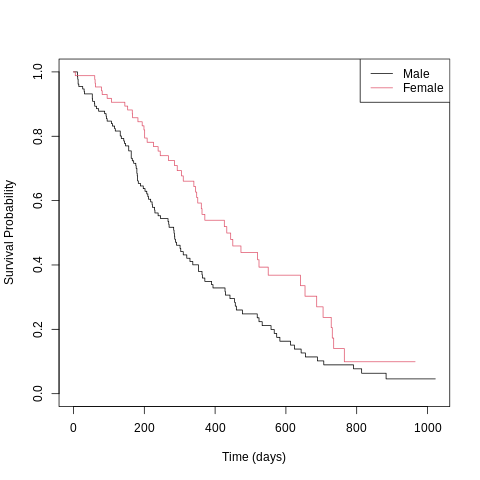

In [ ]:
%%R
# Survival curves by stratum
strat_surv <- survfit(lung_strat_sex)
# Plot
plot(strat_surv, col = 1:2, xlab = "Time (days)", ylab = "Survival Probability")
legend("topright", legend = c("Male", "Female"), col = 1:2, lty = 1)


This plots separate curves for each sex stratum, adjusted for
covariates. For predictions with new data:


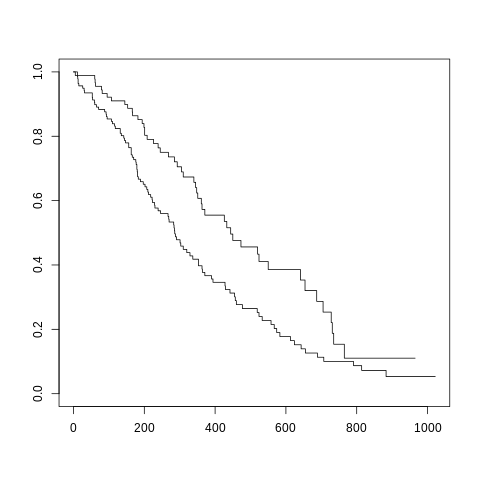

In [ ]:
%%R
new_data <- data.frame(age = 60, wt.loss = 10, sex = c(1, 2))  # Example for male and female
predict_surv <- survfit(lung_strat_sex, newdata = new_data)
plot(predict_surv)

### Additional Considerations


-   If multiple variables violate PH, stratify on one and use
    time-dependent terms (e.g., `tt()`) for others.
-   Compare models using ANOVA: `anova(lung_cox, lung_strat_sex)`.
-   For large datasets or more diagnostics, explore packages like
    `survminer` for enhanced plotting (e.g., `ggcoxzph()` for PH
    checks).
-   Always validate with domain knowledge; stratification is ideal when
    the variable is a nuisance factor rather than of primary interest.

This tutorial provides a basic workflow. Adapt it to your data, and run
diagnostics thoroughly. For more examples, see the `survival` package
vignette: `vignette("survival")`.


## Summary and Conclusion


The Stratified Cox Proportional Hazards Model is a powerful extension of
the standard Cox model that allows for the accommodation of
non-proportional hazards by stratifying the analysis based on
categorical variables that violate the proportional hazards assumption.
This approach enables researchers to control for confounding factors
without estimating their effects directly, thus providing more accurate
estimates for other covariates of interest. This tutorial demonstrated
how to implement a stratified Cox model in R, including fitting the
model, checking assumptions, and interpreting results. By following
these steps, researchers can effectively analyze survival data while
addressing potential violations of model assumptions.


## Resources


1.  "Modeling Survival Data: Extending the Cox Model" by
    Therneau and Grambsch**
    Covers stratification in depth with R examples; Springer, ISBN:
    978-0387987842.

2.  **R survival Package Vignette**
    Official docs with stratified Cox code; access via
    vignette("survival") or
    [CRAN](https://cran.r-project.org/package=survival).

3   **UCLA Tutorial: Survival Analysis in R**
    Practical guide including stratified models; [UCLA
    IDRE](https://stats.idre.ucla.edu/r/seminars/survival-analysis-in-r/).

4.  **survminer Package**
    Visualization tools for stratified Cox (e.g., diagnostics); CRAN
    vignette at
    [survminer](https://cran.r-project.org/package=survminer).

5. **YouTube: MarinStatsLectures Survival Series**
    Video tutorials on Cox models and stratification in R;
    [Playlist](https://www.youtube.com/c/MarinStatsLectures-RProgrammingStatistics/playlists).

6. **Coursera: Survival Analysis in R**
    Course with stratified Cox labs; by Imperial College
    [Coursera](https://www.coursera.org/learn/survival-analysis-r-public-health).
